# Scaling the Dataset

In [8]:
# Imports
import numpy as np

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt 
%matplotlib inline

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Load data
data_directory = 'D:/book-implementations/packt-modern-computer-vision-with-pytorch/3-building-deep-nn-with-pytorch/images/FMNIST'
fmnist = datasets.FashionMNIST(
    data_directory,
    download=False,
    train=True
    )

tr_images = fmnist.data
tr_targets = fmnist.targets 

In [4]:
# Dataset

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255           # Scale the data
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y 
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x.to(device), y.to(device)

In [5]:
def get_data():
    ds = FMNISTDataset(tr_images, tr_targets)
    dl = DataLoader(
        ds,
        batch_size=32,
        shuffle=True
    )
    return dl

In [6]:
# Model

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr = 1e-2        
        )

    return model, loss_fn, optimizer

In [12]:
# Training Function
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    predictions = model(x)
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Accuracy
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    predictions = model(x)
    max_values, argmax = predictions.max(-1)
    is_correct = argmax == y 
    return is_correct.cpu().numpy().tolist()

In [16]:
# Model Training
train_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []

for epoch in range(5):
    print("Epoch: ", epoch)
    epoch_losses, epoch_accuracies = [], []

    for index, data in enumerate(iter(train_dl)):
        x, y = data 
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)

        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for index, data in enumerate(iter(train_dl)):
        x, y = data 
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)

    epoch_accuracy = np.mean(epoch_accuracies)

    print(f"Loss: {epoch_loss}      Accuracy: {epoch_accuracy}")

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)


Epoch:  0
Loss: 0.838165403954188      Accuracy: 0.8063833333333333
Epoch:  1
Loss: 0.5341512230555217      Accuracy: 0.8294333333333334
Epoch:  2
Loss: 0.4808228340069453      Accuracy: 0.8403333333333334
Epoch:  3
Loss: 0.4532307109276454      Accuracy: 0.84905
Epoch:  4
Loss: 0.433839905611674      Accuracy: 0.85485


C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


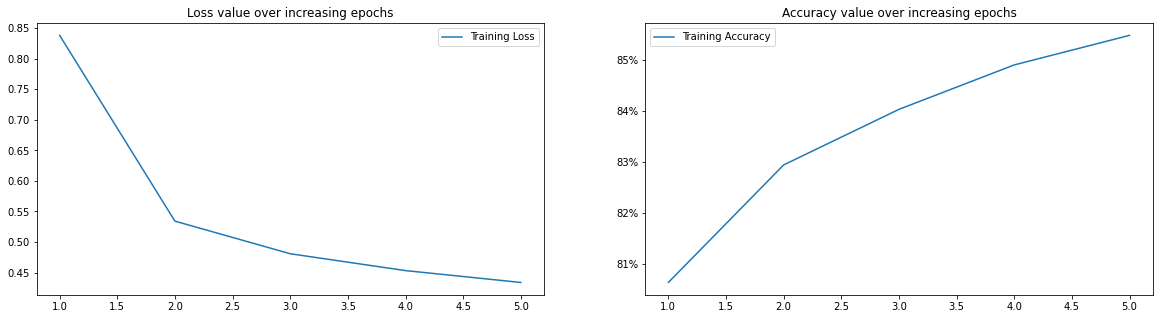

In [18]:
epochs = np.arange(5)+1

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()